In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple, defaultdict
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

# Results

## Wildstyle failures

In [2]:
ws = analyze.Analysis('results/wildstyle')
print(ws)

Analysis for Celeritas v0.4.0-rc.2 on wildstyle


In [3]:
ftab = analyze.make_failure_table(ws.failures())
ftab.to_frame()

,Failure
cms2018+field+msc/vecgeom+cpu (0),internal assertion failed: `track.make_geo_vie...


In [5]:
ftab.to_dict()

{'cms2018+field+msc/vecgeom+cpu (0)': 'internal assertion failed: `track.make_geo_view().pos() != orig_pos` at `PropagationApplier.hh:116`'}

Unconverged tracks (from runs that didn't fail):

In [4]:
summed = analyze.summarize_instances(ws.result[['unconverged']])
unconv = summed[('unconverged', 'mean')]
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


## Summit

In [2]:
summit = analyze.Analysis('results/summit')
print(summit)

Analysis for Celeritas v0.4.0-10+1782ddbdb on summit


Average number of unconverged tracks:

In [3]:
unconv = analyze.summarize_instances(summit.result['unconverged'])['mean']
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


In [4]:
tpp = analyze.summarize_instances(summit.result['avg_time_per_primary'])

In [5]:
tpp.xs('testem3-flat+field+msc', level='problem')

count      mean       std
geo     arch                               
geant4  g4          6.0  0.116498  0.000143
orange  cpu         6.0  0.022556  0.000174
        cpu+g4      6.0  0.095169  0.000425
        gpu         6.0  0.000784  0.000002
        gpu+g4      6.0  0.001321  0.000019
        gpu+sync    6.0  0.000797  0.000002
vecgeom cpu         6.0  0.022960  0.000038
        cpu+g4      6.0  0.093772  0.000206
        gpu         6.0  0.001583  0.000005
        gpu+g4      6.0  0.002168  0.000017
        gpu+sync    6.0  0.001603  0.000012

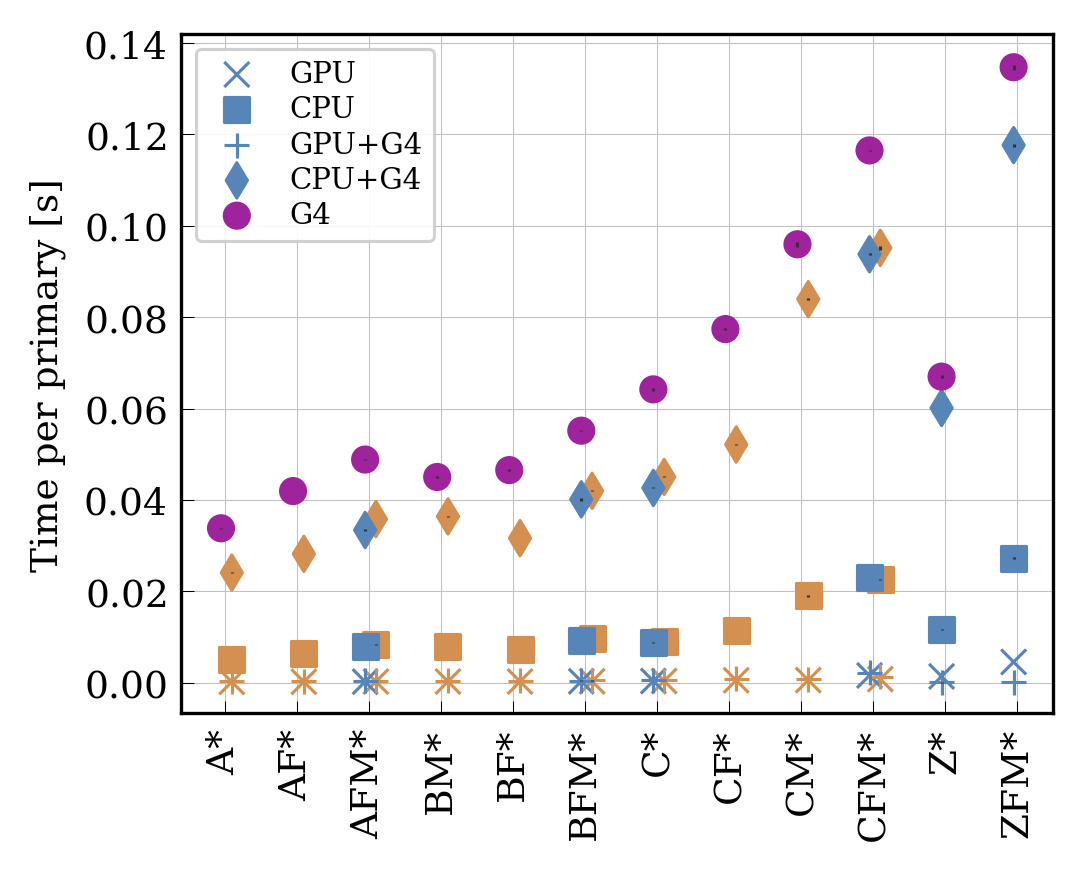

In [10]:
(fig, ax) = plt.subplots()
summit.plot_results(ax, tpp)
ax.legend()
ax.set_ylabel("Time per primary [s]")
fig.savefig("test.png", dpi=150)

In [12]:
!open .

## Crusher

In [9]:
def get_step_times(results):
    new_idx = []
    times = []
    for i in results.index:
        try:
            outp = results.load_results(i, 0)
            step_times = analyze.StepTimeGetter(outp, stream=0)()
        except Exception:
            continue
        times.append([step_times[i] for i in range(2)])
        new_idx.append(i)
    return pd.DataFrame(times, index=pd.MultiIndex.from_tuples(new_idx))

In [4]:
crusher = analyze.Analysis('results/crusher')
print(crusher)

Analysis for Celeritas v0.4.0 on crusher


In [21]:
analyze.get_device_properties(crusher)

{'can_map_host_memory': True,
 'capability_major': 9,
 'capability_minor': 0,
 'clock_rate': 1700000,
 'device_id': 0,
 'eu_per_cu': 4,
 'max_blocks_per_grid': 2147483647,
 'max_cache_size': 8388608,
 'max_threads_per_block': 1024,
 'max_threads_per_cu': 2048,
 'memory_clock_rate': 1600000,
 'multiprocessor_count': 110,
 'name': 'gfx90a',
 'platform': 'hip',
 'regs_per_block': 65536,
 'shared_mem_per_block': 65536,
 'threads_per_warp': 64,
 'total_const_mem': 2147483647,
 'total_global_mem': 68702699520}

## Frontier

In [3]:
frontier = analyze.Analysis('results/frontier')
print(frontier)

Analysis for Celeritas v0.4.0 on frontier


In [40]:
ftab = analyze.make_failure_table(frontier.failures())
ftab.to_frame()

,Failure


In [15]:
failed_pga = ~frontier.successful.unstack('instance').any(axis=1)

In [16]:
failed_pga[frontier.summed.index].groupby('problem').any()

problem
simple-cms+field          False
simple-cms+field+msc      False
simple-cms+msc            False
testem15                  False
testem15+field            False
testem15+field+msc        False
testem3-flat              False
testem3-flat+field        False
testem3-flat+field+msc    False
testem3-flat+msc          False
dtype: bool

In [20]:
temp_cpu = failed_pga.xs('cpu', level='arch')

In [25]:
temp_cpu.index.names

FrozenList(['problem', 'geo'])

In [26]:
failed_pga.groupby(temp_cpu.index.names).any()

problem                 geo    
cms2018                 vecgeom     True
cms2018+field+msc       vecgeom     True
simple-cms+field        orange     False
simple-cms+field+msc    orange     False
                        vecgeom     True
simple-cms+msc          orange     False
testem15                orange     False
testem15+field          orange     False
                        vecgeom     True
testem15+field+msc      orange     False
                        vecgeom     True
testem3-flat            orange     False
                        vecgeom     True
testem3-flat+field      orange     False
testem3-flat+field+msc  orange     False
                        vecgeom     True
testem3-flat+msc        orange     False
dtype: bool

## Perlmutter

In [4]:
perlmutter = analyze.Analysis('results/perlmutter')
print(perlmutter)

Analysis for Celeritas v0.4.0-7+8d085a63f on perlmutter


In [30]:
testem3 = perlmutter.result.xs('testem3-flat+field+msc', level='problem').xs('orange', level='geo')
event_per_sec = testem3['avg_event_per_time'].unstack('arch').describe().loc['mean']
del event_per_sec['gpu+sync']

In [31]:
event_per_sec

arch
cpu    0.126183
gpu    1.612391
Name: mean, dtype: float64

In [32]:
cores_per_job = pd.Series([16, 1], index=event_per_sec.index)
watt_per_card = pd.Series([280, 250], index=event_per_sec.index)
cores_per_card = pd.Series([64, 1], index=event_per_sec.index) # AMD hardware cores, *NOT* threads
watt_per_core = watt_per_card / cores_per_card
watt_per_job = watt_per_core * cores_per_job
event_per_joule = event_per_sec / watt_per_job

In [33]:
event_per_joule

arch
cpu    0.001803
gpu    0.006450
dtype: float64

In [34]:
event_per_joule['gpu'] / event_per_joule['cpu']

3.5779009130190866

In [35]:
event_per_wh = event_per_joule * 60 * 60
event_per_wh

arch
cpu     6.489398
gpu    23.218425
dtype: float64

# Occupancy

In [26]:
problem = "testem3-flat"
kernel_stats = {
    "cuda/vecgeom": analyze.load_kernels(summit, problem, "vecgeom"),
    "cuda/orange": analyze.load_kernels(summit, problem, "orange"),
    "hip/orange": analyze.load_kernels(frontier, problem, "orange"),
}
ksdf = analyze.kernel_stats_dataframe(kernel_stats)

In [27]:
ksdf[ksdf['local_mem'] > 64]

const_mem    heap_size  local_mem  \
arch geo     name                                                   
cuda vecgeom scat-rayleigh          20776      8388608        104   
     orange  initialize-tracks          0      8388608        160   
             photoel-livermore          0      8388608         80   
             scat-rayleigh              0      8388608        104   
             geo-boundary               0      8388608        176   
hip  orange  initialize-tracks          0  68702699520        120   
             geo-boundary               0  68702699520        128   

                                max_blocks_per_cu  max_threads_per_block  \
arch geo     name                                                          
cuda vecgeom scat-rayleigh                      4                    256   
     orange  initialize-tracks                  5                    256   
             photoel-livermore                  3                    256   
             scat-rayleigh                      4                    256   
             geo-boundary                       4                    256   
hip  orange  initialize-tracks                  5                    256   
             geo-boundary                       5                    256   

                                max_warps_per_eu  num_regs  occupancy  \
arch geo     name                                                       
cuda vecgeom scat-rayleigh                    32        64      0.500   
     orange  initialize-tracks                40        48      0.625   
             photoel-livermore                24        68      0.375   
             scat-rayleigh                    32        63      0.500   
             geo-boundary                     32        64      0.500   
hip  orange  initialize-tracks                 5        86      0.625   
             geo-boundary                      5        90      0.625   

                                threads_per_block  kernel_index  register_mem  
arch geo     name                                                              
cuda vecgeom scat-rayleigh                    256            15           256  
     orange  initialize-tracks                256             1           192  
             photoel-livermore                256            12           272  
             scat-rayleigh                    256            15           252  
             geo-boundary                     256            17           256  
hip  orange  initialize-tracks                256             1           344  
             geo-boundary                     256            17           360

# Performance per core

In [5]:
cpu_power_per_task= {
    "summit": 2 * 190 / 6,
    "frontier": 225 / 8, # 64-core AMD “Optimized 3rd Gen EPYC”
    "perlmutter": 280 / 4, # AMD EPYC 7453
}

# Per-task GPU power
gpu_power_per_task = {
    "summit": 250, # V100
    "frontier": 500 / 2, # MI250x
    "perlmutter": 250, # A100
}

cpu_per_task = {
    "summit": 7, # 44 total, 2 reserved for system
    "frontier": 7, # 64 total, 8 reserved
    "perlmutter": 16,
}

In [6]:
def calc_events_per_task_sec(analysis, idx):
    summary = analysis.summed.loc[idx]
#    return analyze.inverse_summary(summary['avg_event_per_time'])
    return summary['avg_event_per_time']

def get_sm_count(analysis):
    return analyze.get_device_properties(analysis)["multiprocessor_count"]

rates = {
    "frontier": calc_events_per_task_sec(frontier, frontier.summed.index),
    "summit": calc_events_per_task_sec(summit, frontier.summed.index),
    "perlmutter": calc_events_per_task_sec(perlmutter, frontier.summed.index),
}

analyses = {
    "summit": summit,
    "perlmutter": perlmutter,
    "frontier": frontier,
}

sm_per_gpu = {k: get_sm_count(v) for k, v in analyses.items()}

sm_per_gpu

{'summit': 80, 'perlmutter': 108, 'frontier': 110}

In [7]:
system_color = {
    "summit": "#7A954F",
    "frontier": "#BC5544",
    "perlmutter": "#3E92C7",
}

In [8]:
for k in rates:
    print(k, rates[k].loc[('testem3-flat', 'orange', 'cpu'), 'mean'],
         rates[k].loc[('testem3-flat', 'orange', 'gpu'), 'mean'])

frontier 0.1499143392240646 1.5860126730382798
summit 0.08835991612886411 2.1261953110268186
perlmutter 0.27973703490667307 3.692726623277196


In [42]:
(fig, ax) = plt.subplots(layout="constrained")
for k in analyses:
    r = rates[k]
    for arch in ['cpu', 'gpu']:
        # events per task-sec
        v = r[r.index.get_level_values("arch") == arch].copy()
        if arch == "cpu":
            v /= cpu_per_task[k] # -> events/cpu-sec
        else:
            v /= sm_per_gpu[k]
        print(k, arch, ":",
              "per core =", v.loc[('testem3-flat', 'orange', arch), 'mean'])
        scat = analyses[k].plot_results(ax, v)
        for s in scat:
            s.set_color(system_color[k])
            s.set_label(f"{k.title()} ({arch.upper()})")
ax.legend()
ax.set_xlabel("Problem")
ax.set_ylabel("Throughput per core/SM [event/s]")
grid = ax.grid(which='both')
fig.savefig('plots/event-per-core.pdf', transparent=True)
plt.close()

summit cpu : per core = 0.012622845161266301
summit gpu : per core = 0.026577441387835233
perlmutter cpu : per core = 0.017483564681667067
perlmutter gpu : per core = 0.03419191317849256
frontier cpu : per core = 0.021416334174866374
frontier gpu : per core = 0.014418297027620725


In [45]:
# Per-task CPU power
joule_per_wh = (3600)

(fig, ax) = plt.subplots(#subplot_kw=dict(yscale="log"),
        layout="constrained")
for k in analyses:
    r = rates[k]
    for arch in ['cpu', 'gpu']:
        v = r[r.index.get_level_values("arch") == arch] # events/(task * s)
        power = (cpu_power_per_task if arch == 'cpu' else gpu_power_per_task)[k] # J / s
        per_wh = v / (power / joule_per_wh) # ==> events / kwh
        print(k, arch, ":",
              "throughput =", v.loc[('testem3-flat', 'orange', arch), 'mean'],
              "power usage = ", power,
              ", per W-h =", per_wh.loc[('testem3-flat', 'orange', arch), 'mean'])
        scat = analyses[k].plot_results(ax, per_wh)
        for s in scat:
            s.set_color(system_color[k])
            s.set_label(f"{k.title()} ({arch.upper()})")

ax.legend()
ax.set_xlabel("Problem")
ax.set_ylabel("Efficiency [event/W-h]")
grid = ax.grid(which='both')
fig.savefig('plots/event-per-energy.pdf', transparent=True)
fig.savefig('plots/event-per-energy.png', transparent=False, dpi=150)
plt.close()

summit cpu : throughput = 0.08835991612886411 power usage =  63.333333333333336 , per W-h = 5.022563653640696
summit gpu : throughput = 2.1261953110268186 power usage =  250 , per W-h = 30.617212478786186
perlmutter cpu : throughput = 0.27973703490667307 power usage =  70.0 , per W-h = 14.386476080914614
perlmutter gpu : throughput = 3.692726623277196 power usage =  250 , per W-h = 53.17526337519162
frontier cpu : throughput = 0.1499143392240646 power usage =  28.125 , per W-h = 19.18903542068027
frontier gpu : throughput = 1.5860126730382798 power usage =  250.0 , per W-h = 22.83858249175123
